## Первоначальный анализ данных и их обработка

### Подготовка и объединение данных

In [1]:
import pandas as pd
import numpy as np
import ast
from pathlib import Path
# Загружаем основные файлы
df = pd.read_csv('dataset/data.csv')
df_genre = pd.read_csv('dataset/data_w_genres.csv')

# В data.csv артисты записаны как "['Artist1', 'Artist2']".
# Берем первого (основного) артиста для мэтчинга.
df['main_artist'] = df['artists'].apply(lambda x: ast.literal_eval(x)[0])

# Объединяем с данными о жанрах
df = pd.merge(df, df_genre[['artists', 'genres']], left_on='main_artist', right_on='artists', how='left')
df.drop('artists_y', axis=1, inplace=True)
df.rename(columns={'artists_x': 'artists'}, inplace=True)

# Заполняем пустые жанры заглушкой
df['genres'] = df['genres'].fillna("['unknown']")

In [2]:
df

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,genres
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,Sergei Rachmaninoff,"['classical', 'post-romantic era', 'russian ro..."
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,...,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029,Anuel AA,"['latin', 'reggaeton', 'reggaeton flow', 'trap..."
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,...,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936,Ashnikko,['pop']
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,...,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688,MAMAMOO,"['k-pop', 'k-pop girl group']"
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,...,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055,Eminem,"['detroit hip hop', 'hip hop', 'rap']"


### Анализ данных (EDA) и выбросы

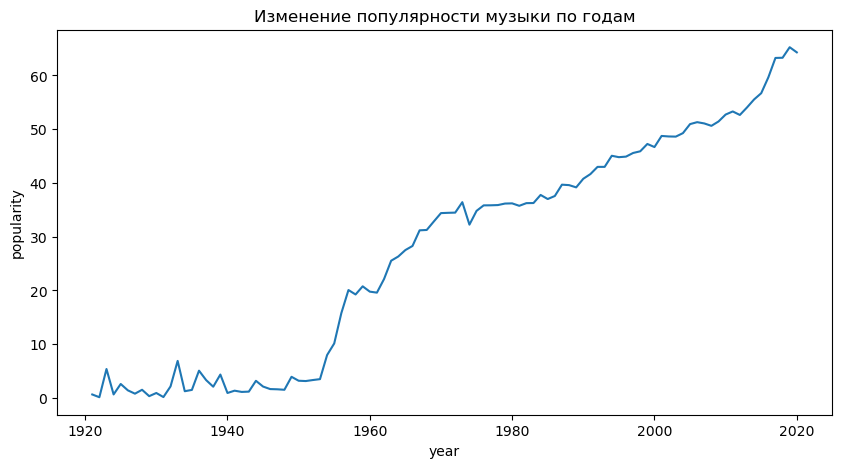

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Популярность по годам (используем data_by_year.csv)
df_year = pd.read_csv('dataset/data_by_year.csv')
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_year, x='year', y='popularity')
plt.title("Изменение популярности музыки по годам")
plt.show()

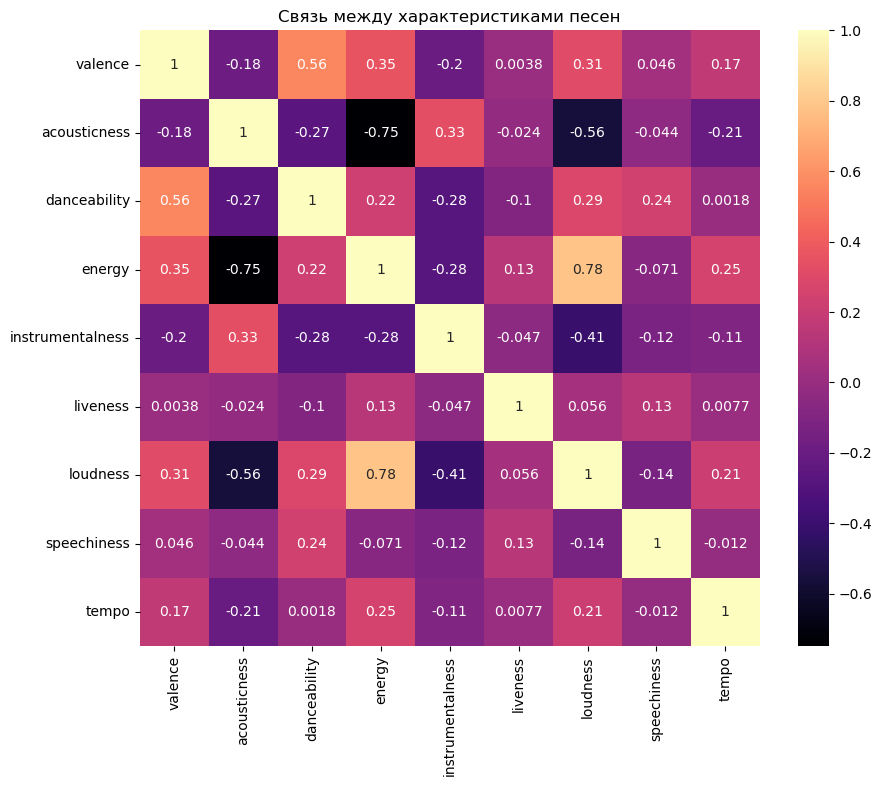

In [4]:
# 2. Корреляция аудио-признаков
features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
            'speechiness', 'tempo']
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='magma')
plt.title("Связь между характеристиками песен")
plt.show()

### Подготовка проверочных данных

In [5]:
# 1. Оставляем только тех артистов, у которых достаточно песен для рекомендаций (например, >= 10)
artist_counts = df['main_artist'].value_counts()
prolific_artists = artist_counts[artist_counts >= 10].index
df_filtered = df[df['main_artist'].isin(prolific_artists)].copy()

# 2. Создаем "Эпохи" по 2 года
df_filtered['epoch'] = (df_filtered['year'] // 2) * 2

# 3. Группируем артиста и эпоху в уникальный ID плейлиста
# Это наш Ground Truth: мы верим, что песни одного артиста в одну эпоху похожи
df_filtered['playlist_id'] = df_filtered['main_artist'] + "_" + df_filtered['epoch'].astype(str)

print(f"Количество песен после фильтрации: {len(df_filtered)}")
print(f"Количество уникальных 'плейлистов' для оценки: {df_filtered['playlist_id'].nunique()}")

Количество песен после фильтрации: 130023
Количество уникальных 'плейлистов' для оценки: 17544


### Создание "Ландшафта"

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 1.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.542510
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.064880
[t-SNE] KL divergence after 300 iterations: 2.924792


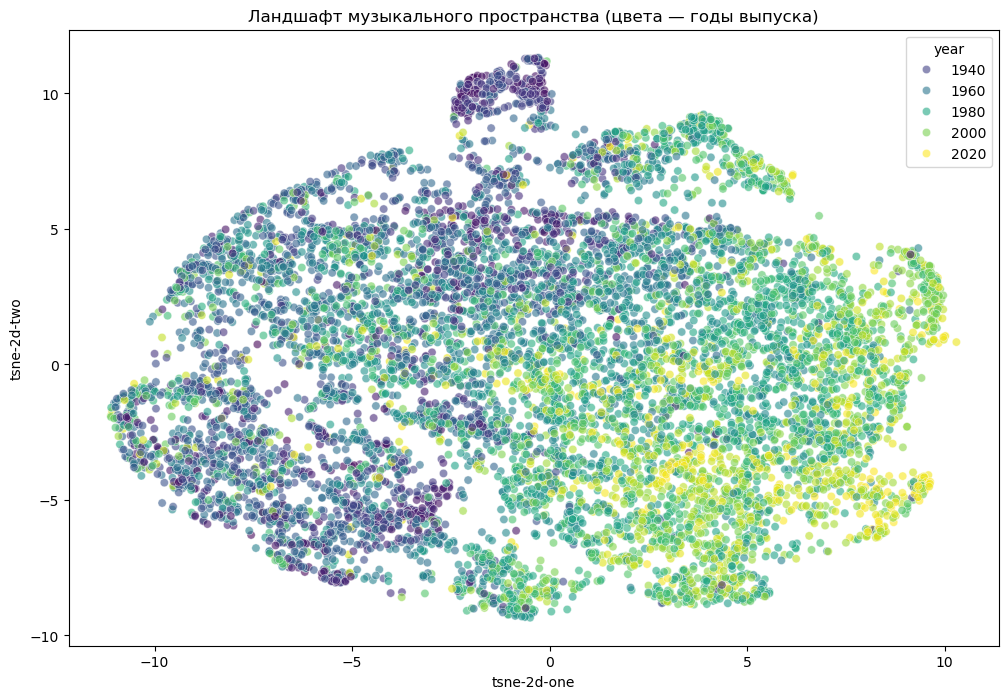

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Берем выборку из отфильтрованных данных
df_sample = df_filtered.sample(min(10000, len(df_filtered)), random_state=42)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sample[features])
try:
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300, random_state=42)
except TypeError:
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

df_sample['tsne-2d-one'] = tsne_results[:, 0]
df_sample['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue='year', data=df_sample, palette='viridis', alpha=0.6)
plt.title("Ландшафт музыкального пространства (цвета — годы выпуска)")
plt.show()

### Сплиттинг и нормализация (для экспериментатора)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Разделяем по плейлистам, чтобы тест был "честным"
unique_playlists = df_filtered['playlist_id'].unique()
train_pl, test_pl = train_test_split(unique_playlists, test_size=0.2, random_state=42)

df_train = df_filtered[df_filtered['playlist_id'].isin(train_pl)]
df_test = df_filtered[df_filtered['playlist_id'].isin(test_pl)]

# Нормализация [0, 1] для автоинкодера
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(df_train[features])
X_test = mm_scaler.transform(df_test[features])

# Сохранение файлов

train_test_dir = Path("experimenter_folder/train_test_npy_and_metadata")
train_test_dir.mkdir(parents=True, exist_ok=True)


np.save(train_test_dir / 'X_train.npy', X_train.astype(np.float32))
np.save(train_test_dir / 'X_test.npy', X_test.astype(np.float32))
df_train.to_csv(train_test_dir / 'metadata_train.csv', index=False)
df_test.to_csv(train_test_dir / 'metadata_test.csv', index=False)

### Эврестический подход (Baseline)

In [8]:
def get_naive_recommendations(target_track_id, n=5):
    track = df_filtered[df_filtered['id'] == target_track_id].iloc[0]
    # Рекомендуем самые популярные треки того же артиста из той же эпохи
    recs = df_filtered[
        (df_filtered['playlist_id'] == track['playlist_id']) &
        (df_filtered['id'] != target_track_id)
        ].sort_values(by='popularity', ascending=False).head(n)
    return recs[['name', 'artists', 'year']]


print("\nПример наивной рекомендации:")
print(get_naive_recommendations(df_filtered['id'].iloc[0]))


Пример наивной рекомендации:
                                                  name  \
53   Rhapsody on a Theme of Paganini, Op. 43: Var. ...   
15   10 Préludes, Op. 23: No. 5 in G Minor. Alla ma...   
132  Suite No. 1, Op. 5 "Fantaisie-tableaux": II. L...   
7    Morceaux de fantaisie, Op. 3: No. 2, Prélude i...   
126                                        III. Adagio   

                                               artists  year  
53   ['Sergei Rachmaninoff', 'Zubin Mehta', 'Vladim...  1921  
15              ['Sergei Rachmaninoff', 'Ruth Laredo']  1921  
132  ['Sergei Rachmaninoff', 'Emanuel Ax', 'Yefim B...  1921  
7                              ['Sergei Rachmaninoff']  1921  
126  ['Sergei Rachmaninoff', 'Yuri Temirkanov', 'St...  1921  


## Обучение нейросети и её настройка

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from numpy.linalg import norm

In [10]:
train_data_slice = 10000 # если нужно быстро проверить модель, то ставим меньшее число, например 10к

X_train_full = np.load(train_test_dir / "X_train.npy")[:train_data_slice]
X_test = np.load(train_test_dir / 'X_test.npy')

metadata_train_full = pd.read_csv(train_test_dir / "metadata_train.csv")[:train_data_slice]
metadata_test = pd.read_csv(train_test_dir / "metadata_test.csv")

print("Train shape:", X_train_full.shape)
print("Train playlists:", metadata_train_full['playlist_id'].nunique())
print("Test shape:", X_test.shape)
print("Test playlists:", metadata_test['playlist_id'].nunique())

Train shape: (10000, 9)
Train playlists: 2829
Test shape: (25817, 9)
Test playlists: 3509


In [11]:
unique_playlists = metadata_train_full['playlist_id'].unique()
train_pl, val_pl = train_test_split(
    unique_playlists, test_size=0.2, random_state=42
)

train_mask = metadata_train_full['playlist_id'].isin(train_pl)
val_mask = metadata_train_full['playlist_id'].isin(val_pl)

X_train = X_train_full[train_mask.values]
X_val = X_train_full[val_mask.values]

metadata_train = metadata_train_full[train_mask].reset_index(drop=True)
metadata_val = metadata_train_full[val_mask].reset_index(drop=True)

print("Train tracks:", len(X_train))
print("Val tracks:", len(X_val))
print("Val playlists:", metadata_val['playlist_id'].nunique())

Train tracks: 7770
Val tracks: 2230
Val playlists: 566


In [12]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-8)


def recall_at_k(recommended, hidden, k):
    return len(set(recommended[:k]) & hidden) / len(hidden)


def ndcg_at_k(recommended, hidden, k):
    dcg = 0.0
    for i, idx in enumerate(recommended[:k]):
        if idx in hidden:
            dcg += 1 / np.log2(i + 2)

    ideal = sum(1 / np.log2(i + 2) for i in range(min(len(hidden), k)))
    return dcg / ideal if ideal > 0 else 0.0


def evaluate_playlist_continuation(df, K=10, hide_frac=0.3):
    recalls, ndcgs = [], []

    for pid, group in df.groupby('playlist_id'):
        if len(group) < 5:
            continue

        indices = group.index.to_numpy()
        np.random.shuffle(indices)

        split = int(len(indices) * (1 - hide_frac))
        known_idx = indices[:split]
        hidden_idx = indices[split:]

        known_z = np.vstack(df.loc[known_idx, 'z'])
        hidden = set(hidden_idx)

        playlist_vec = known_z.mean(axis=0)

        scores = []
        for idx, z in zip(df.index, df['z']):
            scores.append((idx, cosine_similarity(playlist_vec, z)))

        scores.sort(key=lambda x: x[1], reverse=True)
        recommended = [idx for idx, _ in scores if idx not in known_idx]

        recalls.append(recall_at_k(recommended, hidden, K))
        ndcgs.append(ndcg_at_k(recommended, hidden, K))

    return np.mean(recalls), np.mean(ndcgs)


def contrastive_playlist_loss(z, playlist_ids):
    loss = 0.0
    count = 0

    playlist_ids = np.array(playlist_ids)

    for pid in np.unique(playlist_ids):
        idx = np.where(playlist_ids == pid)[0]
        if len(idx) < 2:
            continue

        zi = z[idx]
        center = zi.mean(dim=0)
        loss += ((zi - center) ** 2).sum()
        count += len(idx)

    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count

In [13]:
def evaluate_knn_baseline(df, X, K=10, hide_frac=0.3):
    df = df.copy()
    df['x'] = list(X)

    recalls, ndcgs = [], []

    for pid, group in df.groupby('playlist_id'):
        if len(group) < 5:
            continue

        indices = group.index.values
        np.random.shuffle(indices)

        split = int(len(indices) * (1 - hide_frac))
        known = indices[:split]
        hidden = set(indices[split:])

        playlist_vec = np.vstack(df.loc[known, 'x']).mean(axis=0)

        scores = []
        for idx, x in zip(df.index, df['x']):
            scores.append((idx, cosine_similarity(playlist_vec, x)))

        scores.sort(key=lambda x: x[1], reverse=True)
        recommended = [idx for idx, _ in scores if idx not in known]

        recalls.append(recall_at_k(recommended, hidden, K))
        ndcgs.append(ndcg_at_k(recommended, hidden, K))

    return np.mean(recalls), np.mean(ndcgs)


baseline_recall, baseline_ndcg = evaluate_knn_baseline(
    metadata_val.copy(),
    X_val.copy(),
    K=10
)

print(f"kNN baseline Recall@10: {baseline_recall:.4f}")
print(f"kNN baseline nDCG@10: {baseline_ndcg:.4f}")

kNN baseline Recall@10: 0.0938
kNN baseline nDCG@10: 0.0825


In [14]:
class TracksWithPlaylistDataset(Dataset):
    def __init__(self, X, playlist_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.playlist_ids = np.array(playlist_ids)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.playlist_ids[idx]


train_ds = TracksWithPlaylistDataset(
    X_train,
    metadata_train['playlist_id'].values
)

train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    drop_last=True
)

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        z = nn.functional.normalize(z, dim=1)
        x_hat = self.decoder(z)
        return x_hat, z

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

model = AutoEncoder(input_dim=X_train.shape[1], latent_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


def total_loss(x, x_hat, z, playlist_ids):
    recon = criterion(x_hat, x)
    contrast = contrastive_playlist_loss(z, playlist_ids)
    return recon + lambda_contrast * contrast, recon, contrast


lambda_contrast = 0.1
num_epochs = 30

epoch_loss = []
epoch_recon = []
epoch_contrast = []
val_recalls = []
val_ndcgs = []

Using device: cuda


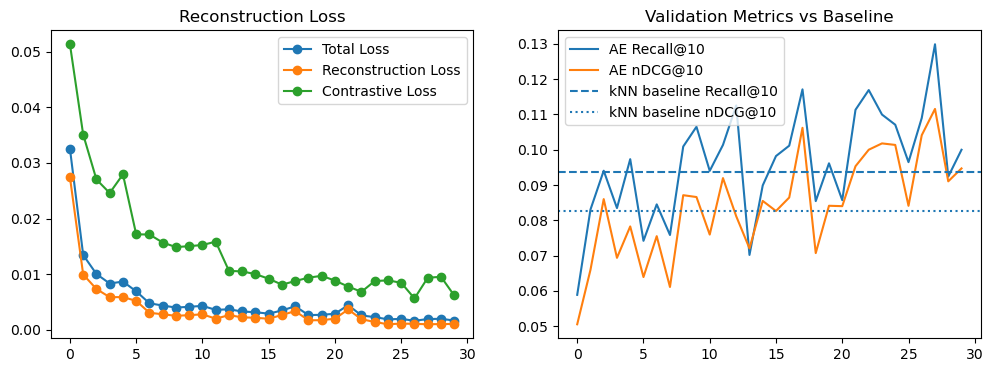

In [17]:
for epoch in range(num_epochs):
    # ===== TRAIN =====
    model.train()

    for x, pid in train_loader:
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, z = model(x)
        loss, recon, contrast = total_loss(x, x_hat, z, pid)

        loss.backward()
        optimizer.step()

    epoch_loss.append(loss.item())
    epoch_recon.append(recon.item())
    epoch_contrast.append(contrast.item())

    # ===== VALIDATION METRIC =====
    model.eval()
    with torch.no_grad():
        Z_val = model.encoder(
            torch.tensor(X_val, device=device)
        ).cpu().numpy()

    metadata_val['z'] = list(Z_val)
    recall_k, ndcg_k = evaluate_playlist_continuation(metadata_val, K=10)

    val_recalls.append(recall_k)
    val_ndcgs.append(ndcg_k)

    # ===== VISUALIZATION =====
    clear_output(wait=False)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epoch_loss, label='Total Loss', marker='o')
    ax[0].plot(epoch_recon, label='Reconstruction Loss', marker='o')
    ax[0].plot(epoch_contrast, label='Contrastive Loss', marker='o')
    ax[0].set_title('Reconstruction Loss')
    ax[0].legend()

    ax[1].plot(val_recalls, label='AE Recall@10')
    ax[1].plot(val_ndcgs, label='AE nDCG@10')

    ax[1].axhline(
        baseline_recall,
        linestyle='--',
        label='kNN baseline Recall@10'
    )

    ax[1].axhline(
        baseline_ndcg,
        linestyle=':',
        label='kNN baseline nDCG@10'
    )

    ax[1].set_title('Validation Metrics vs Baseline')
    ax[1].legend()

    plt.show()